## Smooth Power Law Examples

Below are a few examples of the smoothly broken power law rating curve implementation.

In [1]:
from numpy.typing import ArrayLike
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

Equation for a smoothly broken power law with $n$ breaks is:

\begin{equation}
    f(x) = Ax^{\alpha_0} {\displaystyle \prod^{n}_{i=1}} \Bigg(1 + \bigg(\frac{x}{x_i}\bigg)^{1/\Delta}\Bigg)^{(\alpha_i - \alpha_{i-1})\Delta},
\end{equation}

where $A$ is the scaling amplitude, $\alpha_0$ is the power law slope before the first breakpoint ($x_1$), $\alpha_i$ are the power law slopes between breakpoints $x_{i}$ and $x_{i+1}$ with $i$ being the $i$th breakpoint and $i < n$, $\alpha_n$ is the power law slope after the last breakpoint ($x_n$), and $\Delta$ is the parameter controlling the smoothness of the break. Smaller (non-negative) values of $\Delta$ yield a sharper break, and larger values yield a smoother break.

This equation was adapted from Equation 1 in [Caballero et al. 2023](https://arxiv.org/pdf/2210.14891.pdf).

In log-space:

\begin{equation}
    \log(f(x)) = \log(A) + \alpha_0 \log(x) + {\displaystyle \sum^{n}_{i=1}} (\alpha_i - \alpha_{i-1})\Delta \Bigg(1 + \bigg(\frac{x}{x_i}\bigg)^{1/\Delta}\Bigg),
\end{equation}

In [2]:
def SmoothlyBrokenPowerLaw(x: ArrayLike, amplitude: float, breaks: ArrayLike, alphas: ArrayLike, delta: float) -> np.ndarray:
    breakpoint_array = np.expand_dims(breaks, 0)
    alphas_array = np.array(alphas)
    alphas_diff_array = np.expand_dims(alphas_array[1:] - alphas_array[:-1], 0)
    x_array = np.expand_dims(x, 1)
    prod_array = (1 + (x_array/breakpoint_array) ** (1/delta)) ** (alphas_diff_array * delta)
    fx = amplitude * x ** alphas[0] * np.prod(prod_array, axis=1)
    return fx

Now that we have created to equation function, let's generate some simulated data.

<function matplotlib.pyplot.show(close=None, block=None)>

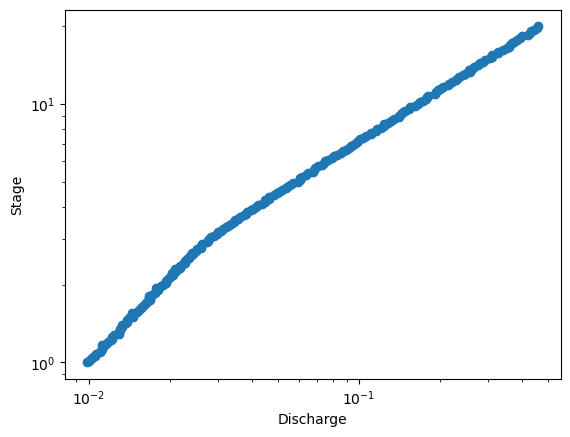

In [3]:
h = np.geomspace(1, 20, 200)
a = 0.01
delta = 0.1
breaks = [3]
alphas = [0.9, 1.5]
q = SmoothlyBrokenPowerLaw(h, a, breaks, alphas, delta)
# Add some random noise in log space
q = np.exp(np.log(q) + np.random.randn(len(q)) * 0.01)

fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.show

Then fit the simulated data and plot the fits.

In [4]:
from ratingcurve.modelbuilder_ratings import SmoothlyBrokenPowerLawRatingModel

# initialize the model
# Default model configurations are okay, as we want uniform priors and 2 segments
smoothpowerrating = SmoothlyBrokenPowerLawRatingModel()
smoothpowerrating.fit(h, q)
data = smoothpowerrating.table()

Convergence achieved at 69500
Interrupted at 69,499 [34%]: Average Loss = 2.8472e+06
Sampling: [a, alpha, delta, hs_, model_q, sigma]
Sampling: [model_q]


Sampling: [model_q]


<function matplotlib.pyplot.show(close=None, block=None)>

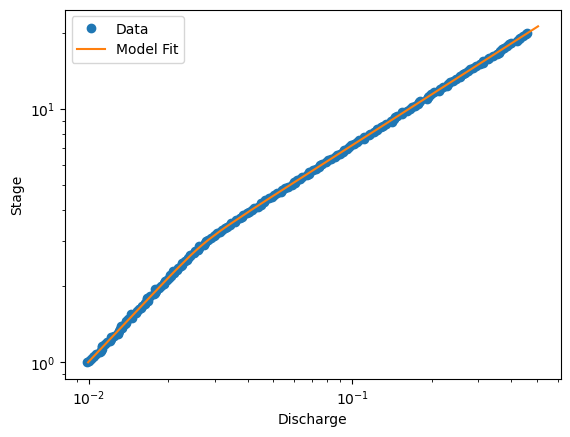

In [5]:
fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='', label='Data')
ax.loglog(data['discharge'], data['stage'], label='Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.legend()
plt.show

Sampling: [model_q]


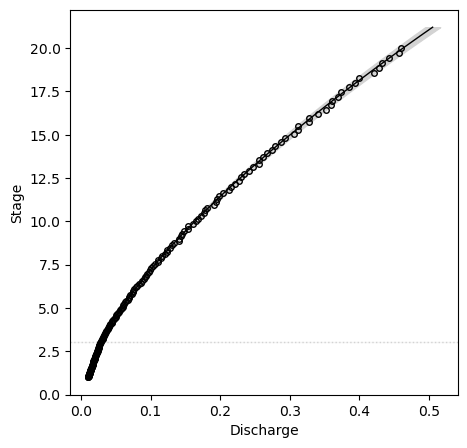

In [6]:
smoothpowerrating.plot()

Sampling: [model_q]


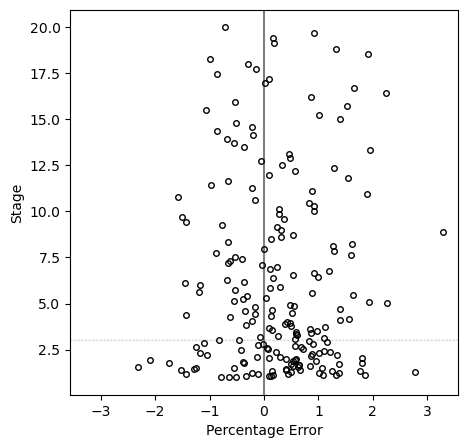

In [7]:
smoothpowerrating.plot_residuals()

So, the fit looks good compared to the data. Let's also check the derived values.

In [8]:
print('Power law slopes expected values: '+str(alphas)+', Derived values: '
      +str(smoothpowerrating.idata.posterior.alpha.mean(dim=['draw']).values.squeeze())+' +/- '+str(smoothpowerrating.idata.posterior.alpha.std(dim=['draw']).values.squeeze()))
print('Break point expected values: '+str(breaks)+', Derived values: '
      +str(smoothpowerrating.idata.posterior.hs.mean(dim=['draw']).values.squeeze())+' +/- '+str(smoothpowerrating.idata.posterior.hs.std(dim=['draw']).values.squeeze()))
print('Normalization expected values: '+str(a)+', Derived values: '
      +str(np.exp(smoothpowerrating.idata.posterior.a.mean(dim=['draw']).values.squeeze()))+' +/- '+
      str(np.exp(smoothpowerrating.idata.posterior.a.mean(dim=['draw']).values.squeeze()) * smoothpowerrating.idata.posterior.a.std(dim=['draw']).values.squeeze()))
print('Smoothness parameter expected values: '+str(delta)+', Derived values: '
      +str(smoothpowerrating.idata.posterior.delta.mean(dim=['draw']).values.squeeze())+' +/- '+str(smoothpowerrating.idata.posterior.delta.std(dim=['draw']).values.squeeze()))

Power law slopes expected values: [0.9, 1.5], Derived values: [0.91077855 1.50125234] +/- [0.00078504 0.00082279]
Break point expected values: [3], Derived values: 3.0391328472676986 +/- 0.00508648898206887
Normalization expected values: 0.01, Derived values: 0.009937905500508909 +/- 7.118633582983549e-06
Smoothness parameter expected values: 0.1, Derived values: 0.08872834289438866 +/- 0.006402770245311619


Now let's test both models on some real data to see how they compare on something less biased toward a certain model.

<function matplotlib.pyplot.show(close=None, block=None)>

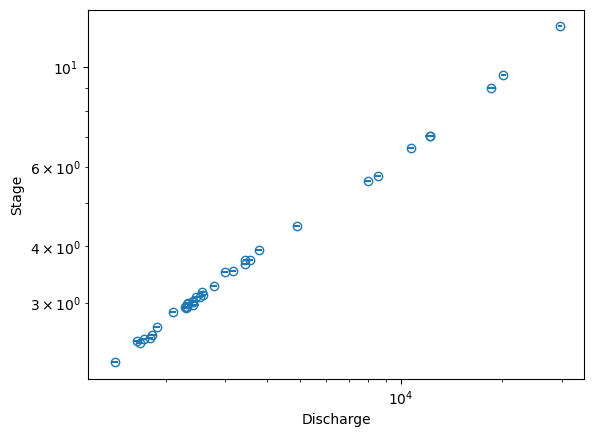

In [9]:
from ratingcurve import data

# load tutorial data
df = data.load('green channel')

fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.show

In [10]:
# initialize the model
# Again we only need 2 segments (the default)
smoothpowerrating_gc = SmoothlyBrokenPowerLawRatingModel(method='nuts')
smoothpowerrating_gc.fit(df['stage'], df['q'], q_sigma=df['q_sigma'])
data_gc = smoothpowerrating_gc.table(np.geomspace(df['stage'].min(), df['stage'].max(), 201))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, a, delta, sigma, hs_]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [a, alpha, delta, hs_, model_q, sigma]
Sampling: [model_q]


Sampling: [model_q]


<function matplotlib.pyplot.show(close=None, block=None)>

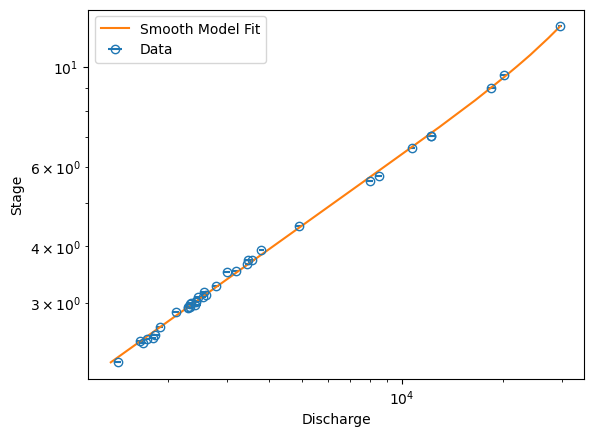

In [11]:
fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none', label='Data')
ax.loglog(data_gc['discharge'], data_gc['stage'], label='Smooth Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.legend()
plt.show

In [12]:
print('Power law slopes derived values: '
      +str(smoothpowerrating_gc.idata.posterior.alpha.mean(dim=['chain', 'draw']).values.squeeze())+' +/- '+str(smoothpowerrating_gc.idata.posterior.alpha.std(dim=['chain', 'draw']).values.squeeze()))
print('Break point derived values: '
      +str(smoothpowerrating_gc.idata.posterior.hs.mean(dim=['chain', 'draw']).values.squeeze())+' +/- '+str(smoothpowerrating_gc.idata.posterior.hs.std(dim=['chain', 'draw']).values.squeeze()))
print('Smoothness parameter derived values: '
      +str(smoothpowerrating_gc.idata.posterior.delta.mean(dim=['chain', 'draw']).values.squeeze())+' +/- '+str(smoothpowerrating_gc.idata.posterior.delta.std(dim=['chain', 'draw']).values.squeeze()))

Power law slopes derived values: [1.8840244  1.26364736] +/- [0.02444913 0.37948102]
Break point derived values: 9.270576851544044 +/- 1.596317875192147
Smoothness parameter derived values: 0.05567328696891408 +/- 0.055743190856795945


Sampling: [model_q]


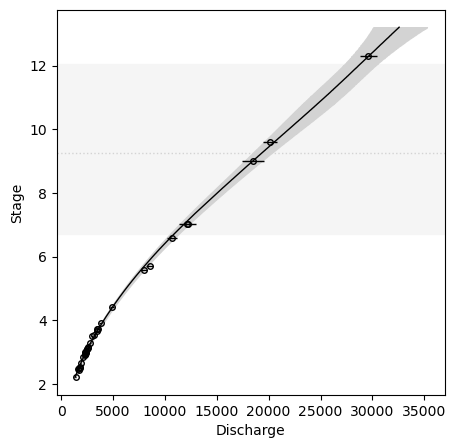

In [13]:
smoothpowerrating_gc.plot()